### Цирулев Н.В. М8О-408Б-22
# Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией)

In [5]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TEST_SIZE = 0.2

TUNE_N_CLF = 20000
CV_SPLITS_CLF = 2

CV_SPLITS_REG = 5


def eval_clf(y_true, y_pred, title: str):
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"precision: {precision:.6f}")
    print(f"recall:    {recall:.6f}")
    print(f"f1:        {f1:.6f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["legitimate(0)", "phishing(1)"]).plot(values_format="d")
    plt.title(title)
    plt.show()

    return {"precision": precision, "recall": recall, "f1": f1}


def eval_reg(y_true, y_pred, title: str):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {title} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2:   {r2:.5f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def load_from_kagglehub(dataset_id: str) -> pd.DataFrame:
    path = kagglehub.dataset_download(dataset_id)
    root = Path(path)
    csv_path = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    print("Loaded:", dataset_id)
    print("CSV:", csv_path)
    print("Shape:", df.shape)
    return df


def parse_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan


def clean_laptop(df_in: pd.DataFrame) -> pd.DataFrame:
    dfc = df_in.copy()
    dfc.columns = dfc.columns.str.strip()

    for col in ["ram_gb", "ssd", "hdd", "graphic_card_gb", "os_bit", "rating", "processor_gnrtn"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].map(parse_number)

    if "Price" in dfc.columns:
        dfc["Price"] = pd.to_numeric(dfc["Price"], errors="coerce")

    for col in ["Number of Ratings", "Number of Reviews"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc

### Имплементации алгоритмов:

In [6]:
class LogisticRegressionScratchGD:
    def __init__(self, lr=0.05, epochs=20, batch_size=4096, l2=1.0, class_weight=None, verbose=False):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.l2 = float(l2)
        self.class_weight = class_weight
        self.verbose = bool(verbose)
        self.w = None
        self.b = 0.0
        self.classes_ = np.array([0, 1], dtype=int)

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -60, 60)
        return 1.0 / (1.0 + np.exp(-z))

    def _make_sample_weight(self, y):
        if self.class_weight != "balanced":
            return None
        y = y.astype(int)
        n = len(y)
        n0 = max(1, np.sum(y == 0))
        n1 = max(1, np.sum(y == 1))
        w0 = n / (2.0 * n0)
        w1 = n / (2.0 * n1)
        return np.where(y == 0, w0, w1).astype(np.float32)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        X = np.ascontiguousarray(X)
        y = np.asarray(y, dtype=np.float32)

        n, d = X.shape
        self.w = np.zeros(d, dtype=np.float32)
        self.b = 0.0

        sw = self._make_sample_weight(y)
        idx = np.arange(n)

        for ep in range(1, self.epochs + 1):
            np.random.shuffle(idx)
            for start in range(0, n, self.batch_size):
                end = min(start + self.batch_size, n)
                bidx = idx[start:end]
                Xb = X[bidx]
                yb = y[bidx]

                logits = Xb @ self.w + self.b
                p = self._sigmoid(logits)

                if sw is None:
                    err = (p - yb)
                    gw = (Xb.T @ err) / len(yb) + self.l2 * self.w
                    gb = float(np.mean(err))
                else:
                    wb = sw[bidx]
                    err = (p - yb) * wb
                    gw = (Xb.T @ err) / np.sum(wb) + self.l2 * self.w
                    gb = float(np.sum(err) / np.sum(wb))

                self.w -= self.lr * gw.astype(np.float32)
                self.b -= self.lr * gb

            if self.verbose and (ep % 5 == 0 or ep == 1 or ep == self.epochs):
                pred = self.predict(X)
                f1v = f1_score(y.astype(int), pred.astype(int), pos_label=1, zero_division=0)
                print(f"epoch {ep}/{self.epochs} f1={f1v:.6f}")

        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        X = np.ascontiguousarray(X)
        p1 = self._sigmoid(X @ self.w + self.b).astype(np.float32)
        p0 = (1.0 - p1).astype(np.float32)
        return np.vstack([p0, p1]).T

    def predict(self, X):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= 0.5).astype(int)


class LinearRegressionScratch:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        X1 = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])
        self.w = np.linalg.lstsq(X1, y, rcond=None)[0]
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        X1 = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])
        return X1 @ self.w


class RidgeRegressionScratch:
    def __init__(self, alpha=1.0):
        self.alpha = float(alpha)
        self.w = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        X1 = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])

        d = X1.shape[1]
        A = X1.T @ X1
        reg = np.eye(d, dtype=np.float64) * self.alpha
        reg[0, 0] = 0.0
        b = X1.T @ y

        self.w = np.linalg.solve(A + reg, b)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        X1 = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])
        return X1 @ self.w

### Классификация

Loaded: ndarvind/phiusiil-phishing-url-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\ndarvind\phiusiil-phishing-url-dataset\versions\1\PhiUSIIL_Phishing_URL_Dataset.csv
Shape: (235795, 55)

=== baseline_sklearn_logreg ===
precision: 0.999752
recall:    0.999653
f1:        0.999703


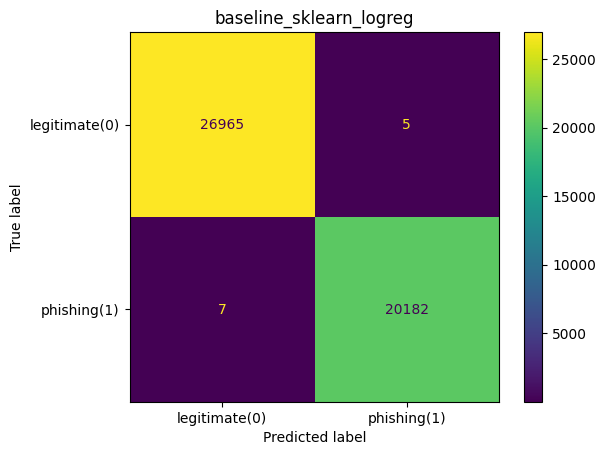

Fitting 2 folds for each of 10 candidates, totalling 20 fits

=== improved_sklearn_logreg ===
precision: 1.000000
recall:    0.999851
f1:        0.999926


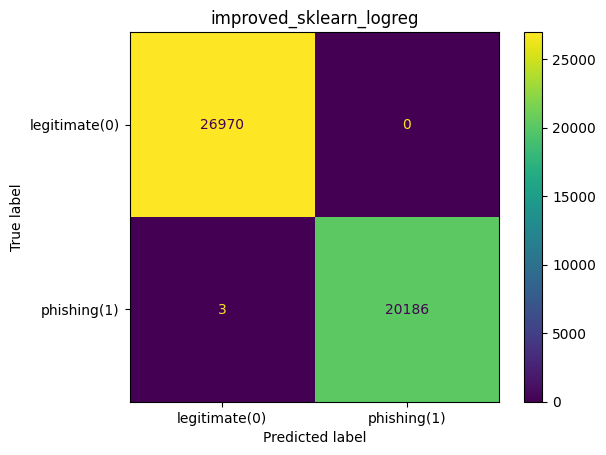

c:\Users\WARMACHINE\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\WARMACHINE\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== baseline_scratch_logreg ===
precision: 0.555096
recall:    0.910496
f1:        0.689704


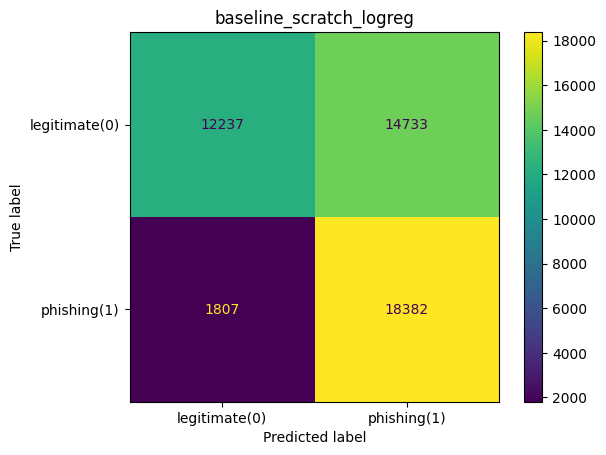


=== improved_scratch_logreg ===
precision: 0.997026
recall:    0.996384
f1:        0.996705


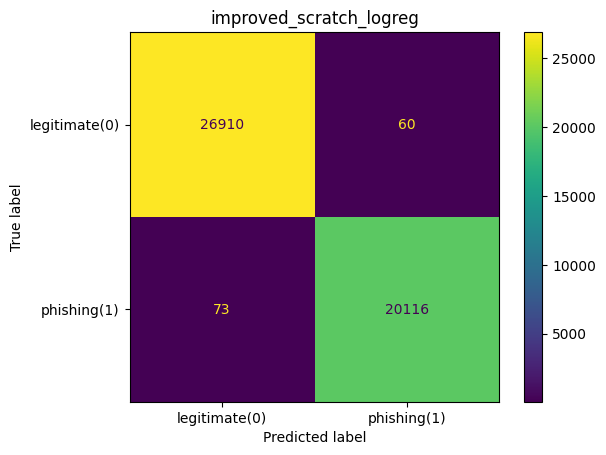


Classification comparison:


,precision,recall,f1
baseline_sklearn,0.999752,0.999653,0.999703
improved_sklearn,1.000000,0.999851,0.999926
baseline_scratch,0.555096,0.910496,0.689704
improved_scratch,0.997026,0.996384,0.996705


In [7]:
# Создание бейзлайна и оценка качества:
df_clf = load_from_kagglehub("ndarvind/phiusiil-phishing-url-dataset")

y_clf = (df_clf["label"] == 0).astype(int)
X_clf = df_clf.drop(columns=["label"])

text_cols_clf = [c for c in ["URL", "Domain", "TLD", "Title"] if c in X_clf.columns]
num_cols_clf = [c for c in X_clf.columns if c not in text_cols_clf]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf,
    test_size=TEST_SIZE,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

Xtr_clf = X_train_clf[num_cols_clf].to_numpy(dtype=np.float32)
Xte_clf = X_test_clf[num_cols_clf].to_numpy(dtype=np.float32)
logreg_base = LogisticRegression(
    solver="lbfgs",
    max_iter=8000,
    tol=1e-3,
    C=0.5
)
logreg_base.fit(Xtr_clf, y_train_clf)
pred_base_clf = logreg_base.predict(Xte_clf)
baseline_sklearn_clf = eval_clf(y_test_clf, pred_base_clf, "baseline_sklearn_logreg")
# Улучшение бейзлайна
# Гипотезы: StandardScaler улучшит качество/стабильность и сходимость; подбор C и class_weight по CV улучшит F1.
tune_n = min(TUNE_N_CLF, len(X_train_clf))
X_tune_clf, _, y_tune_clf, _ = train_test_split(
    X_train_clf[num_cols_clf], y_train_clf,
    train_size=tune_n,
    stratify=y_train_clf,
    random_state=RANDOM_STATE
)

pipe_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="lbfgs", max_iter=4000))
])

param_grid_logreg = {
    "lr__C": [0.01, 0.1, 1.0, 10.0, 30.0],
    "lr__class_weight": [None, "balanced"]
}

cv_clf = StratifiedKFold(n_splits=CV_SPLITS_CLF, shuffle=True, random_state=RANDOM_STATE)

search_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=param_grid_logreg,
    scoring="f1",
    refit=True,
    cv=cv_clf,
    n_jobs=-1,
    verbose=2
)
search_logreg.fit(X_tune_clf, y_tune_clf)

best_logreg = search_logreg.best_estimator_
best_logreg.fit(X_train_clf[num_cols_clf], y_train_clf)
pred_impr_clf = best_logreg.predict(X_test_clf[num_cols_clf])
improved_sklearn_clf = eval_clf(y_test_clf, pred_impr_clf, "improved_sklearn_logreg")

Xtr_clf_scaled = best_logreg.named_steps["scaler"].transform(Xtr_clf).astype(np.float32)
Xte_clf_scaled = best_logreg.named_steps["scaler"].transform(Xte_clf).astype(np.float32)

C_best = float(search_logreg.best_params_["lr__C"])
cw_best = search_logreg.best_params_["lr__class_weight"]
l2_best = 1.0 / C_best

scratch_logreg_base = LogisticRegressionScratchGD(
    lr=0.05, epochs=15, batch_size=4096, l2=1.0, class_weight=None, verbose=False
)
scratch_logreg_base.fit(Xtr_clf, np.asarray(y_train_clf, dtype=np.float32))
pred_s_base_clf = scratch_logreg_base.predict(Xte_clf)
baseline_scratch_clf = eval_clf(y_test_clf, pred_s_base_clf, "baseline_scratch_logreg")

scratch_logreg_impr = LogisticRegressionScratchGD(
    lr=0.05, epochs=25, batch_size=4096, l2=l2_best, class_weight=cw_best, verbose=False
)
scratch_logreg_impr.fit(Xtr_clf_scaled, np.asarray(y_train_clf, dtype=np.float32))
pred_s_impr_clf = scratch_logreg_impr.predict(Xte_clf_scaled)
improved_scratch_clf = eval_clf(y_test_clf, pred_s_impr_clf, "improved_scratch_logreg")

compare_clf = pd.DataFrame(
    [baseline_sklearn_clf, improved_sklearn_clf, baseline_scratch_clf, improved_scratch_clf],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nClassification comparison:")
display(compare_clf)

По sklearn логистическая регрессия показала очень высокое качество уже в бейзлайне (precision=0.999752, recall=0.999653, f1=0.999703), а улучшенная версия дала небольшой прирост (precision=1.000000, recall=0.999851, f1=0.999926). В scratch результаты бейзлайна сильно хуже (precision=0.555096, recall=0.910496, f1=0.689704), но после улучшений качество стало высоким (precision=0.997026, recall=0.996384, f1=0.996705). По сравнению с прошлой ЛР (KNN) улучшенная логистическая регрессия на sklearn дала более высокий F1 (0.999926 против 0.998761 у improved KNN).


### Регрессия

In [10]:
df_reg_raw = load_from_kagglehub("anubhavgoyal10/laptop-prices-dataset")
df_reg = clean_laptop(df_reg_raw)

y_reg = df_reg["Price"].astype(float)
X_reg = df_reg.drop(columns=["Price"])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

num_cols_reg = [c for c in X_train_reg.columns if pd.api.types.is_numeric_dtype(X_train_reg[c])]
cat_cols_reg = [c for c in X_train_reg.columns if c not in num_cols_reg]

ohe_base = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

prep_base_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_reg),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe_base)]), cat_cols_reg)
    ],
    remainder="drop"
)

Xtr_reg_base = prep_base_reg.fit_transform(X_train_reg)
Xte_reg_base = prep_base_reg.transform(X_test_reg)

Xtr_reg_base = np.asarray(Xtr_reg_base, dtype=np.float64)
Xte_reg_base = np.asarray(Xte_reg_base, dtype=np.float64)

lin_base = LinearRegression()
lin_base.fit(Xtr_reg_base, y_train_reg)
pred_base_reg = lin_base.predict(Xte_reg_base)
baseline_sklearn_reg = eval_reg(y_test_reg, pred_base_reg, "baseline_sklearn_linear")

# Гипотезы: Ridge + подбор alpha улучшит обобщение при one-hot; log1p(Price) может улучшить качество из-за перекоса цен; выбираем лучший вариант по CV.
try:
    ohe_impr = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=True)
except TypeError:
    try:
        ohe_impr = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse=True)
    except TypeError:
        ohe_impr = OneHotEncoder(handle_unknown="ignore", sparse=True)

prep_impr_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols_reg),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe_impr)]), cat_cols_reg)
    ],
    remainder="drop"
)

alphas = np.logspace(-3, 4, 12)

ridge_plain = Pipeline([("prep", prep_impr_reg), ("ridge", Ridge())])
search_plain = GridSearchCV(
    ridge_plain,
    param_grid={"ridge__alpha": alphas},
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=KFold(n_splits=CV_SPLITS_REG, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=2
)
search_plain.fit(X_train_reg, y_train_reg)

ridge_log = TransformedTargetRegressor(
    regressor=Pipeline([("prep", prep_impr_reg), ("ridge", Ridge())]),
    func=np.log1p,
    inverse_func=np.expm1
)
search_log = GridSearchCV(
    ridge_log,
    param_grid={"regressor__ridge__alpha": alphas},
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=KFold(n_splits=CV_SPLITS_REG, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=2
)
search_log.fit(X_train_reg, y_train_reg)

best_plain_score = float(search_plain.best_score_)
best_log_score = float(search_log.best_score_)

use_log = best_log_score > best_plain_score
best_model_reg = search_log.best_estimator_ if use_log else search_plain.best_estimator_

print("\nCV best (plain ridge) MAE:", -best_plain_score)
print("CV best (log ridge)   MAE:", -best_log_score)
print("Chosen improved model:", "ridge_log" if use_log else "ridge_plain")

best_model_reg.fit(X_train_reg, y_train_reg)
pred_impr_reg = best_model_reg.predict(X_test_reg)
improved_sklearn_reg = eval_reg(y_test_reg, pred_impr_reg, "improved_sklearn_ridge (chosen by CV)")

if use_log:
    alpha_best = float(best_model_reg.regressor_.named_steps["ridge"].alpha)
    prep_final = best_model_reg.regressor_.named_steps["prep"]
    Xtr_reg_impr = prep_final.fit_transform(X_train_reg)
    Xte_reg_impr = prep_final.transform(X_test_reg)
    Xtr_reg_impr = np.asarray(Xtr_reg_impr, dtype=np.float64)
    Xte_reg_impr = np.asarray(Xte_reg_impr, dtype=np.float64)

    scratch_ridge = RidgeRegressionScratch(alpha=alpha_best)
    y_train_log = np.log1p(np.asarray(y_train_reg, dtype=np.float64))
    scratch_ridge.fit(Xtr_reg_impr, y_train_log)
    pred_s_log = scratch_ridge.predict(Xte_reg_impr)
    pred_s_impr = np.expm1(pred_s_log)
else:
    alpha_best = float(best_model_reg.named_steps["ridge"].alpha)
    prep_final = best_model_reg.named_steps["prep"]
    Xtr_reg_impr = prep_final.fit_transform(X_train_reg)
    Xte_reg_impr = prep_final.transform(X_test_reg)
    Xtr_reg_impr = np.asarray(Xtr_reg_impr, dtype=np.float64)
    Xte_reg_impr = np.asarray(Xte_reg_impr, dtype=np.float64)

    scratch_ridge = RidgeRegressionScratch(alpha=alpha_best)
    scratch_ridge.fit(Xtr_reg_impr, np.asarray(y_train_reg, dtype=np.float64))
    pred_s_impr = scratch_ridge.predict(Xte_reg_impr)

scratch_lin = LinearRegressionScratch()
scratch_lin.fit(Xtr_reg_base, np.asarray(y_train_reg, dtype=np.float64))
pred_s_base_reg = scratch_lin.predict(Xte_reg_base)
baseline_scratch_reg = eval_reg(y_test_reg, pred_s_base_reg, "baseline_scratch_linear")

improved_scratch_reg = eval_reg(y_test_reg, pred_s_impr, "improved_scratch_ridge (chosen by CV)")

compare_reg = pd.DataFrame(
    [baseline_sklearn_reg, improved_sklearn_reg, baseline_scratch_reg, improved_scratch_reg],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nRegression comparison:")
display(compare_reg)

print("\nImproved alpha:", alpha_best)
print("Improved uses log target:", use_log)

Loaded: anubhavgoyal10/laptop-prices-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\anubhavgoyal10\laptop-prices-dataset\versions\1\laptopPrice.csv
Shape: (823, 19)

=== baseline_sklearn_linear ===
MAE:  15633.242
RMSE: 24887.438
R2:   0.68217
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits

CV best (plain ridge) MAE: 15279.488518445598
CV best (log ridge)   MAE: 12495.53233020496
Chosen improved model: ridge_log

=== improved_sklearn_ridge (chosen by CV) ===
MAE:  13470.549
RMSE: 23615.297
R2:   0.71383

=== baseline_scratch_linear ===
MAE:  15633.242
RMSE: 24887.438
R2:   0.68217

=== improved_scratch_ridge (chosen by CV) ===
MAE:  13470.549
RMSE: 23615.297
R2:   0.71383

Regression comparison:


,MAE,RMSE,R2
baseline_sklearn,15633.242407,24887.437745,0.682172
improved_sklearn,13470.548535,23615.297445,0.713834
baseline_scratch,15633.242407,24887.437745,0.682172
improved_scratch,13470.548535,23615.297445,0.713834



Improved alpha: 1.5199110829529332
Improved uses log target: True


Во 2-й ЛР линейная регрессия (baseline_sklearn) дала MAE=15633.24, RMSE=24887.44 и R2=0.68217, а улучшенная модель (ridge с log-преобразованием цели, chosen by CV) улучшила все три метрики: MAE=13470.55, RMSE=23615.30, R2=0.71383. Scratch-реализация во 2-й ЛР полностью совпала со sklearn и для baseline, и для improved (метрики одинаковые).

Если сравнить с KNN из 1-й ЛР, то improved KNN дал MAE=13450.77 и RMSE=25372.39 при R2=0.66967, а improved ridge из 2-й ЛР — MAE=13470.55, RMSE=23615.30 и R2=0.71383. То есть по MAE улучшенный KNN немного лучше (13450.77 < 13470.55), но по RMSE и R2 лучше улучшенная модель 2-й ЛР (23615.30 < 25372.39 и 0.71383 > 0.66967).
